# Setup

In [7]:
import sys
import os
import pickle
sys.path.append('..')

import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

from scripts.cell_extraction_26N import sliding_window_min_max_mix

# Reading in RAPID array data in depth-space and plotting

In [3]:
data_home = "/Users/emiliolr/Google Drive/My Drive/GTC"
rapid_depth = xr.open_dataset(os.path.join(data_home, 'rapid_26N', 'moc_vertical.nc'))

rapid_depth

<xarray.Dataset>
Dimensions:              (time: 13057, depth: 307)
Coordinates:
  * time                 (time) datetime64[ns] 2004-04-02 ... 2022-02-15
  * depth                (depth) float64 0.0 19.87 39.74 ... 5.976e+03 5.995e+03
Data variables:
    stream_function_mar  (depth, time) float64 ...
Attributes:
    Title:                         RAPID streamfunction
    Institution:                   National Oceanography Centre,UK
    Website:                       http://www.rapid.ac.uk/rapidmoc
    Acknowledgement:               The RAPID 26N AMOC monitoring project is f...
    Created_by:                    Ben Moat
    Creation_date:                 08-Sep-2023
    Principle_investigator:        Ben Moat
    Principle_investigator_email:  ben.moat@noc.ac.uk
    DOI:                           doi: 10.5285/04c79ece-3186-349a-e063-6c86a...

In [4]:
# This temp and salinity data may not be useful for calculating potential density since it's
#   aggregated over longitudes...
rapid_temp_sal = xr.open_dataset(os.path.join(data_home, 'rapid_26N', 'ts_gridded.nc'))
rapid_temp_sal

<xarray.Dataset>
Dimensions:          (time: 13057, depth: 242)
Coordinates:
  * time             (time) datetime64[ns] 2004-04-02 ... 2022-02-15
Dimensions without coordinates: depth
Data variables: (12/19)
    pressure         (depth) float64 ...
    TG_west          (depth, time) float64 ...
    SG_west          (depth, time) float64 ...
    TG_wb3           (depth, time) float64 ...
    SG_wb3           (depth, time) float64 ...
    TG_east          (depth, time) float64 ...
    ...               ...
    TG_east_flag     (depth, time) float64 ...
    SG_east_flag     (depth, time) float64 ...
    TG_marwest_flag  (depth, time) float64 ...
    SG_marwest_flag  (depth, time) float64 ...
    TG_mareast_flag  (depth, time) float64 ...
    SG_mareast_flag  (depth, time) float64 ...
Attributes:
    Title:                         RAPID streamfunction
    Institution:                   National Oceanography Centre,UK
    Website:                       http://www.rapid.ac.uk/rapidmoc
    Acknowledgement:               The RAPID 26N AMOC monitoring project is f...
    Created_by:                    Ben Moat
    Creation_date:                 08-Sep-2023
    Principle_investigator:        Ben Moat
    Principle_investigator_email:  ben.moat@noc.ac.uk
    DOI:                           doi: 10.5285/04c79ece-3186-349a-e063-6c86a...

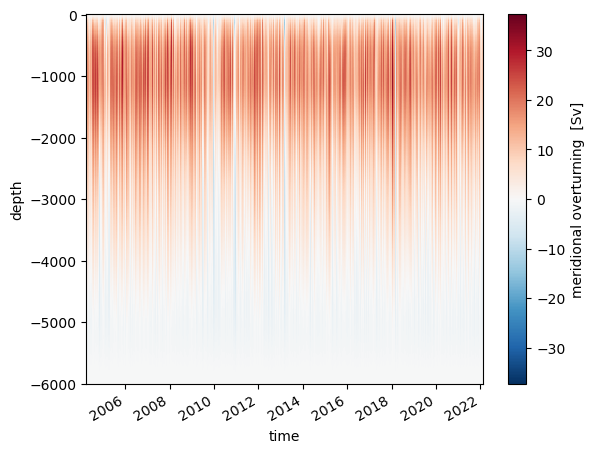

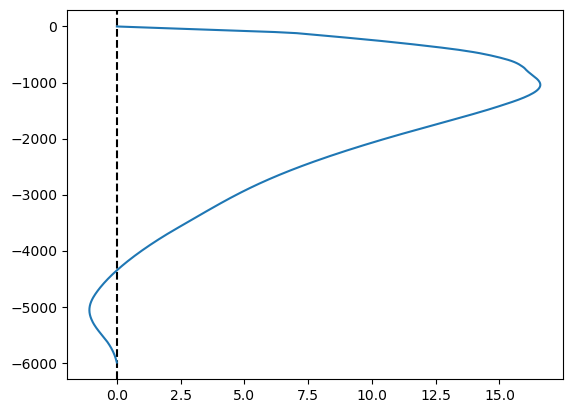

In [5]:
# Pretty sure this is integrating from sea surface down to different depths rather than bottom up...
rapid_flipped = rapid_depth.stream_function_mar.assign_coords({'depth' : -1 * rapid_depth.depth})

rapid_flipped.plot()
plt.show()

plt.axvline(0, color = 'black', linestyle = '--')
plt.plot(rapid_flipped.mean('time'), rapid_flipped.depth)
plt.show()

# Extracting the two cells and the switch point for a 5-month sliding window

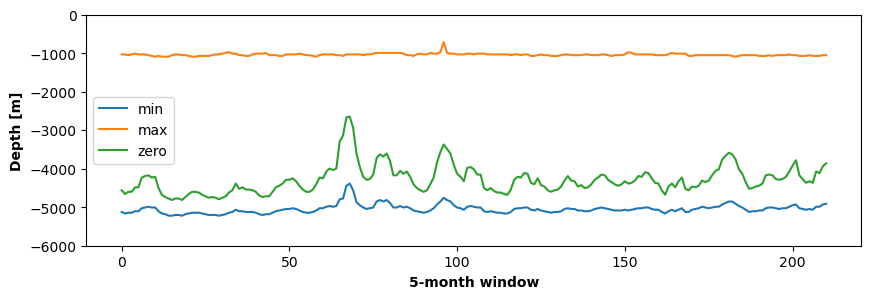

In [6]:
# Calculating the lower/upper cell depths and switch points
min_depths, max_depths, zero_depths = sliding_window_min_max_mix(rapid_flipped)

# Plot these over time--not quite sure how to interpret time dimension because of windows...
plt.figure(figsize = (10, 3))

plt.plot(min_depths, label = 'min')
plt.plot(max_depths, label = 'max')
plt.plot(zero_depths, label = 'zero')

plt.ylim(-6000, 0)

plt.ylabel('Depth [m]', weight = 'bold')
plt.xlabel('5-month window', weight = 'bold')

plt.legend();

# Taking a look at the two cells and switch point in ECCO density-space

In [36]:
# Loading density-space ECCO data
ecco_streamfunction_density_fp = os.path.join(data_home, 'ecco_data_minimal', '26N_streamfunction_density.pickle')

with open(ecco_streamfunction_density_fp, 'rb') as f:
    ecco_streamfunction_density = pickle.load(f)

# Put into an xarray dataset for convenience
ecco_strf = xr.Dataset(data_vars = {'streamfunction' : (['density_layer', 'time'], ecco_streamfunction_density)}, 
                     coords = {'time' : np.arange(0, ecco_streamfunction_density.shape[1], 1), 
                               'depth' : np.arange(0, ecco_streamfunction_density.shape[0], 1)})

ecco_strf.st

<xarray.Dataset>
Dimensions:         (density_layer: 100, time: 312, depth: 100)
Coordinates:
  * time            (time) int64 0 1 2 3 4 5 6 7 ... 305 306 307 308 309 310 311
  * depth           (depth) int64 0 1 2 3 4 5 6 7 8 ... 92 93 94 95 96 97 98 99
Dimensions without coordinates: density_layer
Data variables:
    streamfunction  (density_layer, time) float64 6.305 7.511 ... -0.0 -0.0

In [31]:
ecco_streamfunction_density.shape

(100, 312)

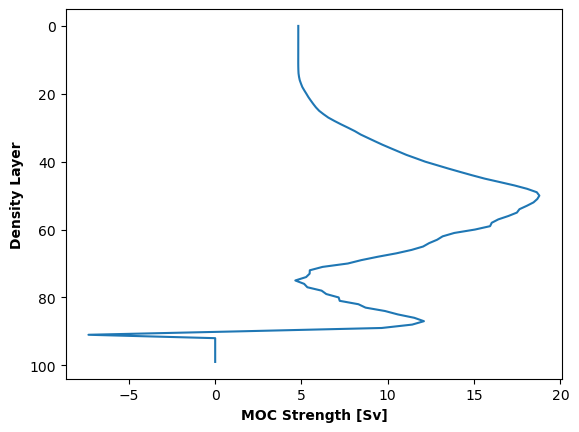

In [27]:
# Plotting streamfunction mean against density layer
plt.plot(ecco_streamfunction_density.mean(axis = 1), np.arange(0, 100, 1))
plt.gca().invert_yaxis()

plt.xlabel('MOC Strength [Sv]', weight = 'bold')
plt.ylabel('Density Layer', weight = 'bold');

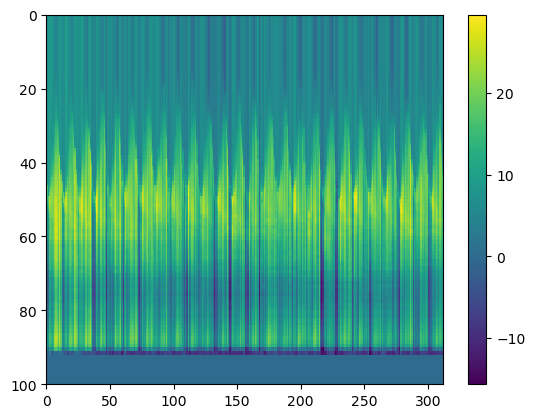

In [35]:
# Plotting streamfunction for density layer vs. time
plt.pcolormesh(ecco_streamfunction_density)
plt.gca().invert_yaxis()

plt.colorbar();